In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import scipy.ndimage

In [2]:
def extract_scalar_data(logdir):
    accumulator = EventAccumulator(logdir, size_guidance={'scalars': 0})
    accumulator.Reload()

    # Extracting 'Testing Error' and 'Training Loss' data
    testing_error = []
    training_loss = []
    if 'Testing Error' in accumulator.Tags()['scalars']:
        for event in accumulator.Scalars('Testing Error'):
            testing_error.append(event.value)
    if 'Training Loss' in accumulator.Tags()['scalars']:
        for event in accumulator.Scalars('Training Loss'):
            training_loss.append(event.value)

    return min(testing_error) if testing_error else float('nan')

In [3]:
def extract_lr_beta1_from_filename(filename):
    components = filename.split('_')
    lr = float(components[2])
    wd = float(components[4])
    return lr, wd

In [13]:
vmin=0.1
vmax=0.4

121
['adam_lr_0.00019531250291038305_wd_1.9531250927684596e-06', 'adam_lr_0.0062500000931322575_wd_9.765625463842298e-07', 'adam_lr_0.0007812500116415322_wd_1.5625000742147677e-05', 'adam_lr_0.02500000037252903_wd_7.812500371073838e-06', 'adam_lr_0.0015625000232830644_wd_0.0010000000474974513', 'adam_lr_0.0015625000232830644_wd_0.0001250000059371814', 'adam_lr_0.0015625000232830644_wd_0.0005000000237487257', 'adam_lr_0.012500000186264515_wd_0.0010000000474974513', 'adam_lr_0.012500000186264515_wd_0.0001250000059371814', 'adam_lr_9.765625145519152e-05_wd_7.812500371073838e-06', 'adam_lr_0.0003906250058207661_wd_1.9531250927684596e-06', 'adam_lr_0.0015625000232830644_wd_1.9531250927684596e-06', 'adam_lr_0.0062500000931322575_wd_3.906250185536919e-06', 'adam_lr_0.012500000186264515_wd_0.0005000000237487257', 'adam_lr_0.0062500000931322575_wd_3.125000148429535e-05', 'adam_lr_0.0003906250058207661_wd_3.125000148429535e-05', 'adam_lr_0.00019531250291038305_wd_1.5625000742147677e-05', 'adam_l

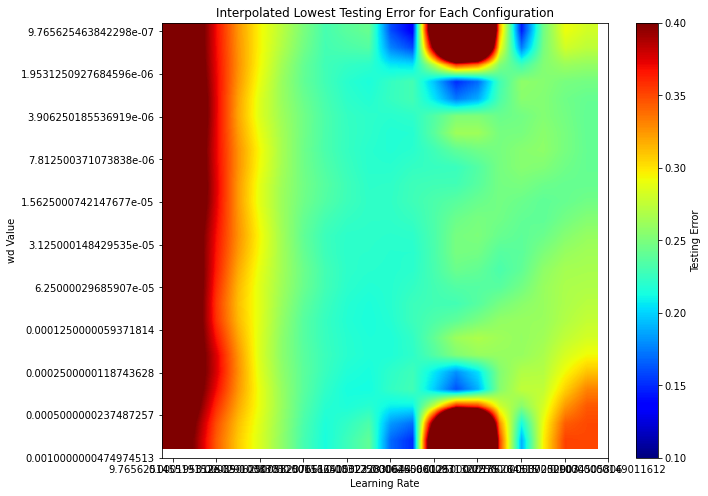

In [26]:
# Load all log directories
log_dir_pattern = 'adam_lr_*'
log_dirs = [d for d in os.listdir('../wd_runs') if re.match(log_dir_pattern, d)]
print(len(log_dirs))
print(log_dirs)

# Extract data and create a dictionary to store the lowest errors
errors_dict = {}
for log_dir in log_dirs:
    lr, wd = extract_lr_beta1_from_filename(log_dir)
    lowest_error = extract_scalar_data(os.path.join('../wd_runs', log_dir))
    errors_dict[(lr, wd)] = lowest_error

# Convert dictionary to a numpy array for heatmap
unique_lrs = sorted(set(lr for lr, _ in errors_dict.keys()))
unique_beta1s = sorted(set(beta1 for _, beta1 in errors_dict.keys()))
lowest_errors = np.zeros((len(unique_beta1s), len(unique_lrs)))

for i, lr in enumerate(unique_lrs):
    for j, wd in enumerate(unique_beta1s):
        lowest_errors[j, i] = errors_dict.get((lr, wd), 1)

lowest_errors = np.nan_to_num(lowest_errors, nan=1)

# Interpolate the data to create a smoother heatmap
x = np.linspace(0, len(unique_lrs)-1, len(unique_lrs))
y = np.linspace(0, len(unique_beta1s)-1, len(unique_beta1s))
x_new = np.linspace(0, len(unique_lrs)-1, 20)  # Increase 4x to 40 for interpolation
y_new = np.linspace(0, len(unique_beta1s)-1, 25)  # Increase 5x to 50 for interpolation

data_interpolated = scipy.ndimage.zoom(lowest_errors, (len(y_new)/len(y), len(x_new)/len(x)))

# Plot interpolated heatmap
plt.figure(figsize=(10, 8))
plt.imshow(data_interpolated, interpolation='bilinear', cmap='jet', aspect='auto', vmin=vmin, vmax=vmax)
plt.colorbar(label='Testing Error')
plt.xticks(ticks=np.linspace(0, 20, len(unique_lrs)), labels=unique_lrs)
plt.yticks(ticks=np.linspace(0, 25, len(unique_beta1s)), labels=unique_beta1s)
plt.xlabel('Learning Rate')
plt.ylabel('wd Value')
plt.title('Interpolated Lowest Testing Error for Each Configuration')
plt.show()

121
['adamw_lr_0.10000000149011612_wd_3.125000148429535e-05', 'adamw_lr_0.012500000186264515_wd_0.0010000000474974513', 'adamw_lr_0.012500000186264515_wd_0.0001250000059371814', 'adamw_lr_0.02500000037252903_wd_0.0002500000118743628', 'adamw_lr_0.10000000149011612_wd_3.906250185536919e-06', 'adamw_lr_0.0015625000232830644_wd_0.0005000000237487257', 'adamw_lr_0.0015625000232830644_wd_0.0010000000474974513', 'adamw_lr_0.0015625000232830644_wd_0.0001250000059371814', 'adamw_lr_0.0062500000931322575_wd_9.765625463842298e-07', 'adamw_lr_0.012500000186264515_wd_0.0005000000237487257', 'adamw_lr_0.0062500000931322575_wd_3.125000148429535e-05', 'adamw_lr_0.0062500000931322575_wd_3.906250185536919e-06', 'adamw_lr_0.0062500000931322575_wd_1.5625000742147677e-05', 'adamw_lr_9.765625145519152e-05_wd_7.812500371073838e-06', 'adamw_lr_0.10000000149011612_wd_9.765625463842298e-07', 'adamw_lr_0.0003906250058207661_wd_3.906250185536919e-06', 'adamw_lr_0.05000000074505806_wd_6.25000029685907e-05', 'adam

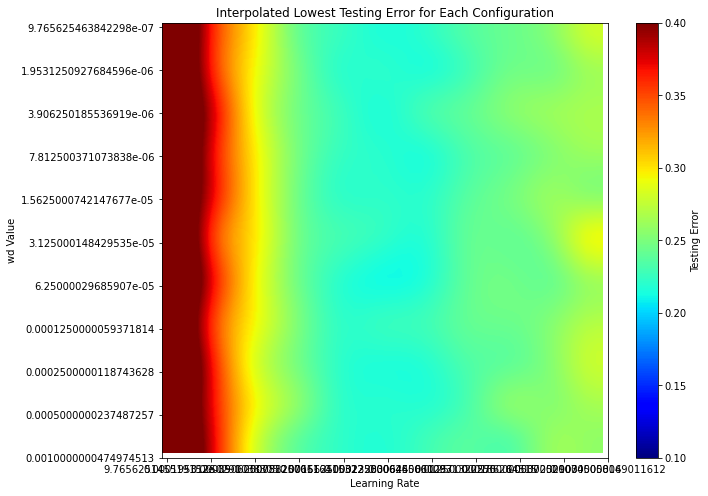

In [20]:
# Load all log directories
log_dir_pattern = 'adamw_*'
log_dirs = [d for d in os.listdir('../wd_runs') if re.match(log_dir_pattern, d)]
print(len(log_dirs))
print(log_dirs)
# Extract data and create a dictionary to store the lowest errors
errors_dict = {}
for log_dir in log_dirs:
    lr, wd = extract_lr_beta1_from_filename(log_dir)
    lowest_error = extract_scalar_data(os.path.join('../wd_runs', log_dir))
    errors_dict[(lr, wd)] = lowest_error

# Convert dictionary to a numpy array for heatmap
unique_lrs = sorted(set(lr for lr, _ in errors_dict.keys()))
unique_beta1s = sorted(set(beta1 for _, beta1 in errors_dict.keys()))
lowest_errors = np.zeros((len(unique_beta1s), len(unique_lrs)))

for i, lr in enumerate(unique_lrs):
    for j, wd in enumerate(unique_beta1s):
        lowest_errors[j, i] = errors_dict.get((lr, wd), np.nan)

# Interpolate the data to create a smoother heatmap
x = np.linspace(0, len(unique_lrs)-1, len(unique_lrs))
y = np.linspace(0, len(unique_beta1s)-1, len(unique_beta1s))
x_new = np.linspace(0, len(unique_lrs)-1, 40)  # Increase 4x to 40 for interpolation
y_new = np.linspace(0, len(unique_beta1s)-1, 50)  # Increase 5x to 50 for interpolation

data_interpolated = scipy.ndimage.zoom(lowest_errors, (len(y_new)/len(y), len(x_new)/len(x)))

# Plot interpolated heatmap
plt.figure(figsize=(10, 8))
plt.imshow(data_interpolated, interpolation='bilinear', cmap='jet', aspect='auto', vmin=vmin, vmax=vmax)
plt.colorbar(label='Testing Error')
plt.xticks(ticks=np.linspace(0, 40, len(unique_lrs)), labels=unique_lrs)
plt.yticks(ticks=np.linspace(0, 50, len(unique_beta1s)), labels=unique_beta1s)
plt.xlabel('Learning Rate')
plt.ylabel('wd Value')
plt.title('Interpolated Lowest Testing Error for Each Configuration')
plt.show()